# A. Import required library

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import jovian

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# B. Preparing the Imagenette2 Dataset

In [ ]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./imagenette2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
# Look into the data directory
data_dir = './data/imagenette2-160'
print(os.listdir(data_dir))

train_dir = data_dir + "/train"
classes = os.listdir(train_dir)
print(classes)


test_dir = data_dir + "/val"
classes2 = os.listdir(test_dir)
print(classes2)

['noisy_imagenette.csv', 'val', '.DS_Store', 'train']
['n03028079', 'n01440764', 'n02979186', 'n02102040', '.DS_Store', 'n03394916', 'n03417042', 'n03888257', 'n03425413', 'n03445777', 'n03000684']
['n03028079', 'n01440764', 'n02979186', 'n02102040', 'n03394916', 'n03417042', 'n03888257', 'n03425413', 'n03445777', 'n03000684']


## 1. Check quantity in each class

In [4]:
train_count =[]
for root, dirs, files in os.walk(train_dir):
  if files == []:
    continue
  else:
    train_count.append(len(files))
    #print(len(files))
    
test_count =[]
for root, dirs, files in os.walk(test_dir):
  if files == []:
    continue
  else:
    test_count.append(len(files))
    #print(len(files))
    
print("Number of items in each training class:", train_count)
print("Number of items in each validating class:", test_count)

Number of items in each training class: [1, 941, 963, 993, 955, 956, 961, 960, 931, 951, 858]
Number of items in each validating class: [409, 387, 357, 395, 394, 389, 390, 419, 399, 386]


## 2. Transform images

In [7]:
# https://www.youtube.com/watch?v=y6IEcEBRZks&t=3s

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))           # Will calculate this later
train_tfms = tt.Compose([ tt.RandomRotation(degrees=5),
                          tt.RandomCrop(160, padding=2, padding_mode='reflect'),
                          tt.ToTensor(),
                          tt.Normalize(*stats, inplace=True)])
                         
test_tfms = tt.Compose([tt.RandomResizedCrop(160),
                         tt.ToTensor(), 
                         tt.Normalize(*stats)])

train_ds = ImageFolder(data_dir+'/train', train_tfms)
test_ds  = ImageFolder(data_dir+'/val',   test_tfms)

In [9]:
classes = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
print(train_ds.classes)
class_dict = dict(zip(train_ds.classes, classes))
class_dict

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


{'n01440764': 'tench',
 'n02102040': 'English springer',
 'n02979186': 'cassette player',
 'n03000684': 'chain saw',
 'n03028079': 'church',
 'n03394916': 'French horn',
 'n03417042': 'garbage truck',
 'n03425413': 'gas pump',
 'n03445777': 'golf ball',
 'n03888257': 'parachute'}

## 3. Example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  church (4)


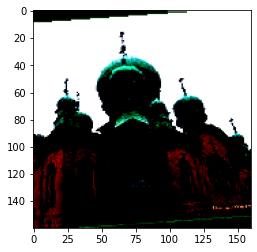

In [10]:
def show_example(img,label):
  print('Label: ', classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))
    
show_example(*train_ds[4000])

# C. Adversarial Attack

## 1. Downloading pretrained model 

In [24]:
import torch 
import os
import torchvision.models as models


os.environ['TORCH_HOME'] = 'models/' #setting the environment variable
#alexnet = models.alexnet(pretrained=True)
#resnet = models.resnet101(pretrained=True)
convnext_tiny = models.convnext_tiny(pretrained=True)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to models/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

## 2. Inputs

In [25]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

#pretrained_model_alexnet = "models/alexnet/hub/checkpoints/alexnet-owt-7be5be79.pth"
#pretrained_model_resnet = "/home/tomarsharvi24/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth"
pretrained_model_convnext = "models/hub/checkpoints/convnext_tiny-983f1562.pth"

## 3. Model Under Attack

In [26]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = convnext_tiny.to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model_convnext, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

## 4. FGSM Attack

In [18]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## 5. Testing Function

In [56]:
ten_classes = [0,1,2,3,4,5,6,7,8,9]
all_classes = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]
conv_dict = dict(zip(all_classes, ten_classes))
conv_dict

{0: 0, 217: 1, 482: 2, 491: 3, 497: 4, 566: 5, 569: 6, 571: 7, 574: 8, 701: 9}

In [58]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        lhs = init_pred.item()
        rhs = target.item()
        
        ## We will have to convert initial pred to a range of 0-9 for checking if it is correct or not
        if lhs not in [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]:
            continue
        elif conv_dict[lhs]!= rhs: continue    

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        
        if final_pred.item() in [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]: 
            pred = conv_dict[final_pred.item()]
         
            #print("Prediction unchanged", final_pred.item(),"Modified", pred, "Actual label", target.item())
            
            if pred == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (conv_dict[lhs], pred, adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (conv_dict[lhs], pred, adv_ex) )
                    
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )            

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## 6.  Preparing test loader

In [20]:
target = []
for i in range(len(test_count)):
    for j in range(test_count[i]):
        target.append(test_ds.classes[i])  
        
test_ds.targets = target
dataloader_test = torch.utils.data.DataLoader(test_ds, batch_size=1)        

## 7. Run Attack

In [59]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1669 / 3925 = 0.4252229299363057
Epsilon: 0.05	Test Accuracy = 1544 / 3925 = 0.39337579617834395
Epsilon: 0.1	Test Accuracy = 1406 / 3925 = 0.35821656050955414
Epsilon: 0.15	Test Accuracy = 1352 / 3925 = 0.3444585987261147
Epsilon: 0.2	Test Accuracy = 1241 / 3925 = 0.3161783439490446
Epsilon: 0.25	Test Accuracy = 1122 / 3925 = 0.28585987261146495
Epsilon: 0.3	Test Accuracy = 1053 / 3925 = 0.26828025477707007


## 8. Results

### Accuracy vs Epsilon

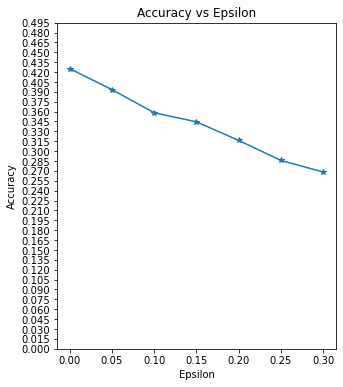

In [60]:
plt.figure(figsize=(5,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 0.5, step=0.015))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples

In [62]:
names = ['tench','English springer', 'cassette player','chain saw','church','French horn','garbage truck','gas pump',
 'golf ball','parachute']
names_dict = dict(zip(ten_classes, names))
names_dict

{0: 'tench',
 1: 'English springer',
 2: 'cassette player',
 3: 'chain saw',
 4: 'church',
 5: 'French horn',
 6: 'garbage truck',
 7: 'gas pump',
 8: 'golf ball',
 9: 'parachute'}

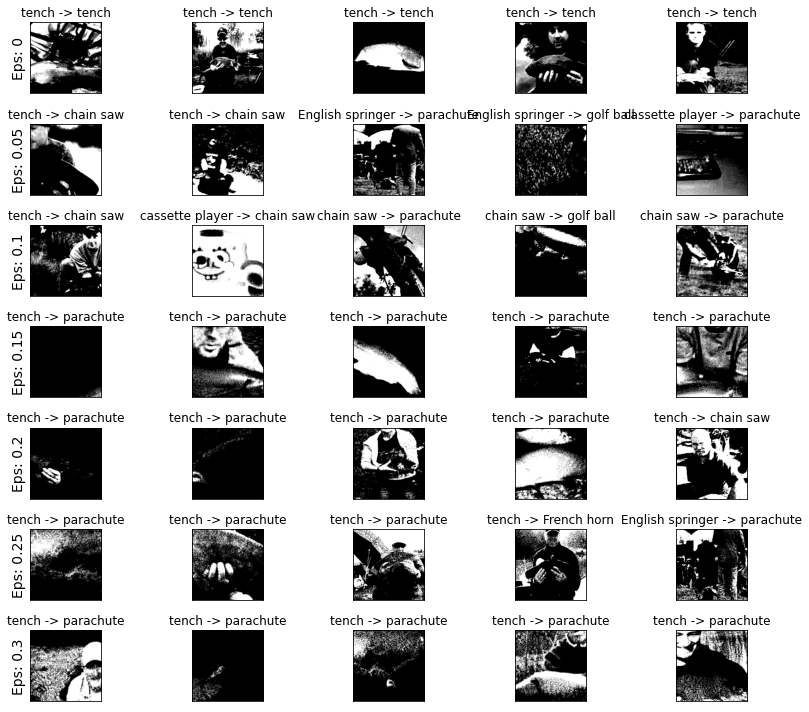

In [82]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(12,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(names_dict[orig], names_dict[adv]))
        #plt.imshow(ex[0,:,:])
        plt.imshow(ex[0,:,:], cmap="gray")

plt.tight_layout()
plt.show()